# EECS 442 Homework 4 - PyTorch ConvNets
In this notebook we will explore how to use a pre-trained PyTorch convolution neural network (ConvNet).

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) David FOUHEY, #12345678

**Your Answer:**   
Hello EECS442 #12345678

## Setup

In [1]:
import os
import json
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

<ipython-input-1-f27d24ff2c2c>:8: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


For all of our experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet [1]. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [2], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all experiments without heavy computation. Run the following cell to download and initialize your model.

[1] Olga Russakovsky*, Jia Deng*, Hao Su, Jonathan Krause, Sanjeev Satheesh, Sean Ma, Zhiheng Huang, Andrej Karpathy, Aditya Khosla, Michael Bernstein, Alexander C. Berg and Li Fei-Fei. ImageNet Large Scale Visual Recognition Challenge. IJCV, 2015

[2] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [3]:
print('Download and load the pretrained SqueezeNet model.')
model = torchvision.models.squeezenet1_1(pretrained=True).to(device)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# Make sure the model is in "eval" mode
model.eval()

# you may see warning regarding initialization deprecated, that's fine, 
# please continue to next steps

Download and load the pretrained SqueezeNet model.


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

Next, we will download the imagenet labels which we are going to use in the notebook. ImageNet labels are stored in the `idx2label` dictionary of `{index(int): label(str)}`. 

In [4]:
# Loading the imagenet class labels
# If this cell failed due to wget probelm, you can put the link below into your browser to download the file directly
# Put the downloaded file under the same directory as this jupyter notebook
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

class_idx = json.load(open("imagenet_class_index.json"))
idx2label = {k:class_idx[str(k)][1] for k in range(len(class_idx))}
idx2label

--2023-04-02 00:36:07--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.197.240, 54.231.162.192, 54.231.134.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.197.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2023-04-02 00:36:07 (1.78 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

### Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. You don't need to do anything in this cell.

In [5]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
              std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
  
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

## Task 6 - Pre-trained Convolution Network
In order to get a better sense of the classification decisions made by convolutional networks, your job is now to experiment by running whatever images you want through a model pretrained on ImageNet. These can be images from your own photo collection, from the internet, or somewhere else but they **should belong to one of the ImageNet classes**. Look at the `idx2label` dictionary for all the ImageNetclasses.

You need to find:
1. One image (`img1`) where the SqueezeNet model gives reasonable predictions, and produces a category label that seems to correctly describe the content of the image
2. One image (`img2`) where the SqueezeNet model gives unreasonable predictions, and produces a category label that does not correctly describe the content of the image.

You can upload images in Colab by using the upload button on the top left. For more details about using Colab, please see our [Colab tutorial](https://web.eecs.umich.edu/~justincj/teaching/eecs442/WI2021/colab.html). 



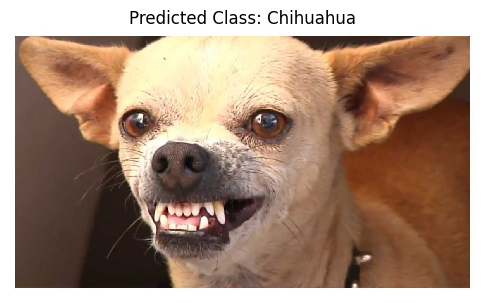

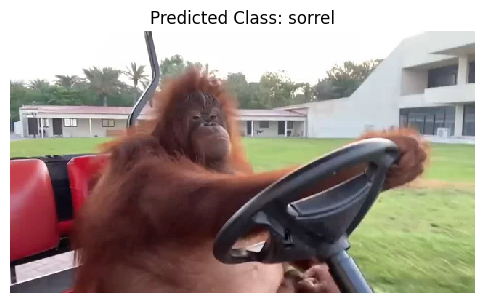

In [13]:
###############################################################################
# TODO: Upload your image and run the forward pass to get the ImageNet class. #
# This code will crash when you run it, since the maxresdefault.jpg image is  #
# not found. You should upload your own images to the Colab notebook and edit #
# these lines to load your own image.                                         #
###############################################################################
img1 = Image.open('ugly.jpg')
img2 = Image.open('orangutan.jpg')
names = ['image1 name', 'image2 name']
##############################################################################
#               END OF YOUR CODE                                             #
##############################################################################
for i, img in enumerate([img1, img2]):
    X = preprocess(img).to(device)
    pred_class = torch.argmax(model(X)).item()
    plt.figure(figsize=(6,8))
    plt.imshow(img)
    plt.title('Predicted Class: %s' % idx2label[pred_class])
    plt.axis('off')
    plt.savefig(f'{names[i]}_pred.jpg')
    plt.show()